In [1]:
import sys
sys.path.append("E:\\Github Projects\\Retinal_Blood_Vessels_Segmentation")

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify
from lightgbm import Booster
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    f1_score,
    precision_score
)

from scripts.prepare_data import create_sliding_window, preprocess_images, get_stats

IMG_SIZE = (960, 960)

In [24]:
def prepare_image_lgbm(image: np.ndarray, channel=1, window_shape=(5, 5), pad=True, padding=(2, 2)) -> np.ndarray:        
    preprocessed_img = preprocess_images([image], channel)
    windows = create_sliding_window(*preprocessed_img, window_shape, pad, padding)
    img_stats = [get_stats(window) for window in windows]
    
    return [stat for stat in img_stats]


def prepare_image_unet(img: np.ndarray):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img/255


def plot_predictions(true_img: np.ndarray, true_mask: np.ndarray, filters_pred: np.ndarray, lgbm_pred: np.ndarray, unet_pred: np.ndarray):
    true_img = cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(true_img)
    plt.title("Real image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 5, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True mask")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 5, 3)
    plt.imshow(filters_pred, cmap='gray')
    plt.title("Filters pred")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 5, 4)
    plt.imshow(lgbm_pred, cmap='gray')
    plt.title("LGBM pred")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 5, 5)
    plt.imshow(unet_pred, cmap='gray')
    plt.title("Unet pred")
    plt.xticks([])
    plt.yticks([])

    plt.show()


def make_prediction_unet(model, img: np.ndarray) -> np.ndarray:
    img_patch_shape = (64, 64, 3)
    mask_patch_shape = (64, 64)

    sample_test_img_patchified = patchify(img, patch_size=img_patch_shape, step=img_patch_shape[0])

    number_of_patches = sample_test_img_patchified.shape[0] * sample_test_img_patchified.shape[1]

    sample_test_img_patches = sample_test_img_patchified.reshape(number_of_patches, *img_patch_shape)
    sample_test_img_patches = np.expand_dims(sample_test_img_patches, axis=0)

    y_pred = np.array([model.predict(sample_patch) for sample_patch in sample_test_img_patches]).reshape(sample_test_img_patchified.shape[0], sample_test_img_patchified.shape[0], *mask_patch_shape)
    y_pred_binarized = np.where(y_pred > 0.5, 1, 0)

    return unpatchify(y_pred_binarized, (960, 960))


def process_image_filters(image_array: np.array):
    image = image_array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    green = image[:, :, 1] # use green channel
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(7,7)) 
    img_clahe = clahe.apply(green) # make clahe form green channel

    kernel_sizes = [5,7,15,23]
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

    morphology_steps = [img_clahe.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([image_opened, image_closed])

    extracted_vessels = cv2.subtract(morphology_steps[-1], img_clahe) # extract vessels

    extracted_clahe = clahe.apply(extracted_vessels) # make clahe from extracted vessels

    _, extracted_clahe_thresh = cv2.threshold(extracted_clahe, 20, 255, cv2.THRESH_BINARY) # threshold

    noise = np.ones(extracted_clahe_thresh.shape[:2], dtype='uint8') * 255  # create noise mask

    contours, _ = cv2.findContours(extracted_clahe_thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # find contours

    for contour in contours:
        if cv2.contourArea(contour) <= 200:
            cv2.drawContours(noise, [contour], -1, 0, -1)

    extracted_vessels_without_noise = cv2.bitwise_and(extracted_clahe, extracted_clahe, mask=noise) # remove noise

    _, extracted_vessels_without_noise_thresh = cv2.threshold(extracted_vessels_without_noise, 20, 255, cv2.THRESH_BINARY) #threshold

    result_img = extracted_vessels_without_noise_thresh

    return result_img/255

In [4]:
unet = load_model('../models/unet.hdf5', compile=False)

lgbm = Booster(model_file='../models/lgbm.txt')

In [31]:
test_dir = "../cropped_images/test"
val_dir = "../cropped_images/val"

test_images_names = os.listdir(f"{test_dir}/img")
test_masks_names = os.listdir(f"{test_dir}/mask")

test_images = [cv2.imread(f"{test_dir}/img/{image}") for image in test_images_names]
test_masks = [cv2.imread(f"{test_dir}/mask/{image}", cv2.IMREAD_GRAYSCALE) for image in test_masks_names]

val_images_names = os.listdir(f"{val_dir}/img")
val_masks_names = os.listdir(f"{val_dir}/mask")

val_images = [cv2.imread(f"{val_dir}/img/{image}") for image in val_images_names]
val_masks = [cv2.imread(f"{val_dir}/mask/{image}", cv2.IMREAD_GRAYSCALE) for image in val_masks_names]

total_images = test_images + val_images[:2]
total_masks = test_masks + val_masks[:2]

In [6]:
unet_images, lgbm_images = [], []

for i, img in enumerate(total_images, start=1):
    print(f"Image {i}/{len(total_images)}")
    unet_images.append(prepare_image_unet(img))
    lgbm_images.append(prepare_image_lgbm(img, 1, (5, 5), True, (2, 2)))

Image 1/5
Image 2/5
Image 3/5
Image 4/5
Image 5/5


In [25]:
unet_preds = [make_prediction_unet(unet, img) for img in unet_images]
print("Unet finished")
filters_preds = [process_image_filters(img) for img in total_images]
print("Filters finished")

lgbm_preds = []
for i, windows in enumerate(lgbm_images, start=1):
    print(f"Image {i}/{len(lgbm_images)}")
    img_pred = lgbm.predict(windows)
        
    img_pred = np.where(np.array(img_pred) > 0.5, 1, 0)
    lgbm_preds.append(np.array(img_pred).reshape(IMG_SIZE))

Unet finished
Filters finished
Image 1/5
Image 2/5
Image 3/5
Image 4/5
Image 5/5


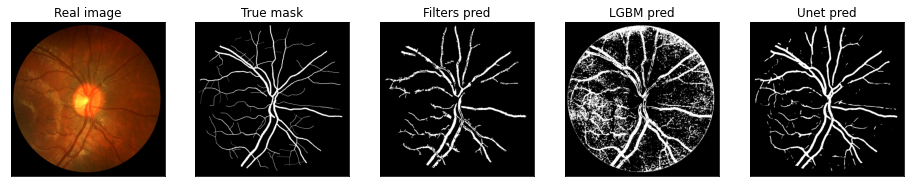

FILTERS METRICS

              F1: 0.6272996612886748
              Accuracy: 0.9485405815972222
              Recall: 0.6722305502686496
              Precision: 0.5879987035181802
LGBM METRICS

              F1: 0.35745916459808164
              Accuracy: 0.8179969618055556
              Recall: 0.7858550470768557
              Precision: 0.23134517074331729
UNET METRICS

              F1: 0.7080554842380631
              Accuracy: 0.9543478732638889
              Recall: 0.8593421030469421
              Precision: 0.6020627315852823


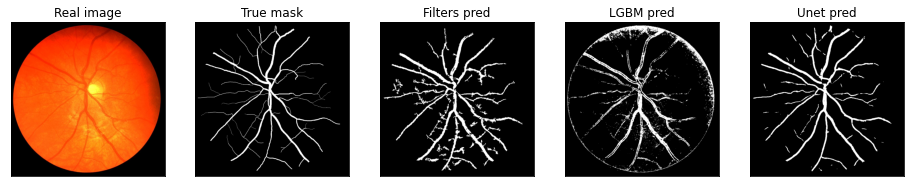

FILTERS METRICS

              F1: 0.6252258816671525
              Accuracy: 0.9441905381944444
              Recall: 0.8392769811616033
              Precision: 0.4981711777615216
LGBM METRICS

              F1: 0.41999563096191656
              Accuracy: 0.9135720486111111
              Recall: 0.5641542283690996
              Precision: 0.33451647701569404
UNET METRICS

              F1: 0.7599149783228464
              Accuracy: 0.9691145833333333
              Recall: 0.8812183336919737
              Precision: 0.6679666068595324


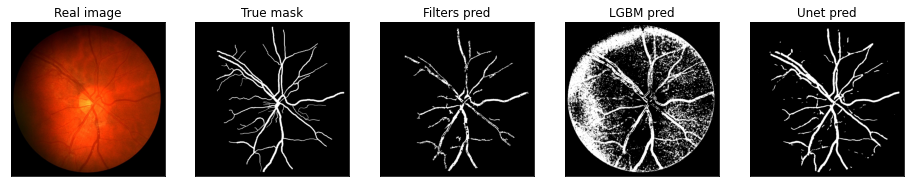

FILTERS METRICS

              F1: 0.6143538747426045
              Accuracy: 0.9583409288194444
              Recall: 0.5450284268120978
              Precision: 0.7038852828798969
LGBM METRICS

              F1: 0.27117611811278863
              Accuracy: 0.7584798177083333
              Recall: 0.738009944928621
              Precision: 0.16610508074803243
UNET METRICS

              F1: 0.742906891780545
              Accuracy: 0.9641124131944444
              Recall: 0.8516637259619669
              Precision: 0.6587810358851345


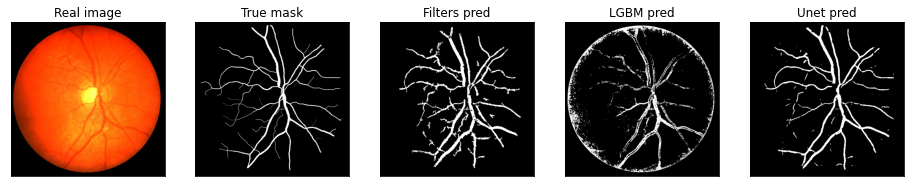

FILTERS METRICS

              F1: 0.6550674206176599
              Accuracy: 0.9509537760416666
              Recall: 0.8393992138149532
              Precision: 0.5371167563508947
LGBM METRICS

              F1: 0.3539637547869614
              Accuracy: 0.90701171875
              Recall: 0.45913597872215595
              Precision: 0.28799420993878727
UNET METRICS

              F1: 0.7631187592946675
              Accuracy: 0.9697536892361112
              Recall: 0.8781022040560891
              Precision: 0.6747618045745544


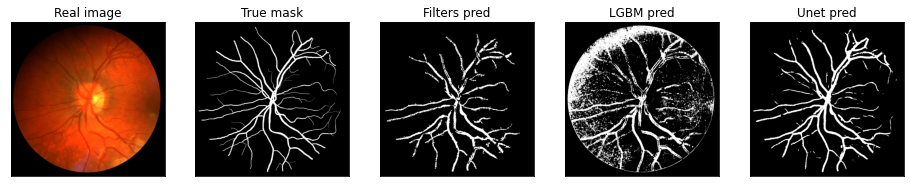

FILTERS METRICS

              F1: 0.6311048296144017
              Accuracy: 0.9439236111111111
              Recall: 0.6403841696604473
              Precision: 0.6220905687990769
LGBM METRICS

              F1: 0.3632910636434217
              Accuracy: 0.8264767795138889
              Recall: 0.6608963958743771
              Precision: 0.25049277176568774
UNET METRICS

              F1: 0.7435962246237878
              Accuracy: 0.9548708767361112
              Recall: 0.8736383126665894
              Precision: 0.6472520042499759


In [52]:
for true_img, true_mask, filters_pred, lgbm_pred, unet_pred in zip(total_images, total_masks, filters_preds, lgbm_preds, unet_preds):
    true_mask = (true_mask/255).astype(int)
    plot_predictions(true_img, true_mask, filters_pred, lgbm_pred, unet_pred)
    print("FILTERS METRICS")
    print(f"""
              F1: {f1_score(true_mask, filters_pred, average='micro')}
              Accuracy: {np.sum(true_mask == filters_pred)/(IMG_SIZE[0]*IMG_SIZE[1])}
              Recall: {recall_score(true_mask, filters_pred, average='micro')}
              Precision: {precision_score(true_mask, filters_pred, average='micro')}""")
    print("LGBM METRICS")
    print(f"""
              F1: {f1_score(true_mask, lgbm_pred, average='micro')}
              Accuracy: {np.sum(true_mask == lgbm_pred)/(IMG_SIZE[0]*IMG_SIZE[1])}
              Recall: {recall_score(true_mask, lgbm_pred, average='micro')}
              Precision: {precision_score(true_mask, lgbm_pred, average='micro')}""")
    print("UNET METRICS")
    print(f"""
              F1: {f1_score(true_mask, unet_pred, average='micro')}
              Accuracy: {np.sum(true_mask == unet_pred)/(IMG_SIZE[0]*IMG_SIZE[1])}
              Recall: {recall_score(true_mask, unet_pred, average='micro')}
              Precision: {precision_score(true_mask, unet_pred, average='micro')}""")